<a href="https://colab.research.google.com/github/Hadarlack/Kaggle_NLP_food_reviews/blob/master/NLP_Food_reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import warnings
warnings.filterwarnings("ignore")                     #Ignoring unnecessory warnings

import numpy as np                                  #for large and multi-dimensional arrays
import pandas as pd                                 #for data manipulation and analysis
import nltk                                         #Natural language processing tool-kit

from nltk.corpus import stopwords                   #Stopwords corpus
from nltk.stem import PorterStemmer                 # Stemmer

from sklearn.feature_extraction.text import CountVectorizer          #For Bag of words
from sklearn.feature_extraction.text import TfidfVectorizer          #For TF-IDF
from gensim.models import Word2Vec                                   #For Word2Vec

In [0]:
from google.colab import files

file=files.upload()
data=pd.read_csv("Reviews.csv")
data.Summary=data.Summary.astype(str)

#data_sel = data.head(10000)                                #Considering only top 10000 rows

In [134]:
# Shape of our data
data.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

In [135]:
data.shape

(568454, 10)

In [136]:
data.head(20)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...
5,6,B006K2ZZ7K,ADT0SRK1MGOEU,Twoapennything,0,0,4,1342051200,Nice Taffy,I got a wild hair for taffy and ordered this f...
6,7,B006K2ZZ7K,A1SP2KVKFXXRU1,David C. Sullivan,0,0,5,1340150400,Great! Just as good as the expensive brands!,This saltwater taffy had great flavors and was...
7,8,B006K2ZZ7K,A3JRGQVEQN31IQ,Pamela G. Williams,0,0,5,1336003200,"Wonderful, tasty taffy",This taffy is so good. It is very soft and ch...
8,9,B000E7L2R4,A1MZYO9TZK0BBI,R. James,1,1,5,1322006400,Yay Barley,Right now I'm mostly just sprouting this so my...
9,10,B00171APVA,A21BT40VZCCYT4,Carol A. Reed,0,0,5,1351209600,Healthy Dog Food,This is a very healthy dog food. Good for thei...


Looks like our main objective from the dataset is to predict whether a review is **Positive** or **Negative** based on the Text/Summary.
 
The Score column has values of 1,2,3,4,5.  Considering 1,2 as Negative reviews and 4,5 as Positive reviews. For Score = 3 I will consider it as Neutral review. I delete the rows that are neutral, so that we can predict either Positive or Negative.
 
HelpfulnessNumerator indicates the number of people that found the review usefull. HelpfulnessDenominator is usefull review count + not so usefull count. So, from this we can see that HelpfulnessNumerator is always less than or equal to HelpfulnesDenominator.

In [0]:
data_score_removed = data[data['Score']!=3]       #Neutral reviews removed

In [138]:
data_score_removed["Usefulness"] = (data_score_removed["HelpfulnessNumerator"]/data_score_removed["HelpfulnessDenominator"]).apply(lambda n: "useful" if n > 0.8 else "useless")
# we can try to predict this feature also later


data_score_removed.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Usefulness
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,useful
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,useless
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,useful
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,useful
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,useless


Converting Score values into class label either Posituve or Negative.

In [139]:
def partition(x):
    if x < 3:
        return 'positive'
    return 'negative'



score_upd = data_score_removed['Score']
data_score_removed['Score']=score_upd.map(partition)

data_score_removed['Score']

0         negative
1         positive
2         negative
3         positive
4         negative
5         negative
6         negative
7         negative
8         negative
9         negative
10        negative
11        negative
12        positive
13        negative
14        negative
15        negative
16        positive
17        negative
18        negative
19        negative
20        negative
21        negative
22        negative
23        negative
24        negative
25        negative
26        positive
27        negative
28        negative
29        negative
            ...   
568424    negative
568425    negative
568426    positive
568427    negative
568428    negative
568429    negative
568430    negative
568431    positive
568432    positive
568433    positive
568434    positive
568435    positive
568436    negative
568437    negative
568438    negative
568439    negative
568440    negative
568441    negative
568442    negative
568443    negative
568444    negative
568445    ne

**Deduplication** in order to get unbaised results. Checking duplicates based on UserId, ProfileName, Time, Text. If all these values are equal then we will remove those records. (No user can type a review on same exact time for different products.)

+ checking that HelpfulnessNumerator is always less than or equal to HelpfulnessDenominator, and removing those records also.

In [0]:
final_data = data_score_removed.drop_duplicates(subset={"UserId","ProfileName","Time","Text"})

In [141]:
final_data.shape

(364173, 11)

In [0]:
final = final_data[final_data['HelpfulnessNumerator'] <= final_data['HelpfulnessDenominator']]

In [143]:
final.shape

(364171, 11)

In [0]:
Summary = final['Summary']
Score = final['Score']

#spliting to train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Summary, Score, test_size=0.2, random_state=42)

In [145]:
X_train.shape

(291336,)

In [146]:
X_test.shape

(72835,)

In [147]:
y_train.shape

(291336,)

In [148]:
y_test.shape

(72835,)

In [149]:
type(X_train)

pandas.core.series.Series

## Cleaning the data

Converting all words to lowercase and removing punctuations.
Conducting Stemming (tastefully, tasty -> stem word called 'tasti')
Removing Stop words

In [150]:
import string
stemmer = PorterStemmer() # grain word
from nltk.corpus import stopwords
import nltk
nltk.download('punkt')

def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item)) # a list of the grain word of each row in the summary vector
    return stemmed

def tokenize(text):
    tokens = nltk.word_tokenize(text) # splitting each summary to words
    #tokens = [word for word in tokens if word not in stopwords.words('english')]
    
    stems = stem_tokens(tokens, stemmer) # each word to its grain word
    return ' '.join(stems) # a list of the grain words of each summary

intab = string.punctuation
outtab = "                                "
trantab = str.maketrans(intab, outtab) # a dictionary


       

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In first data cleaning (tokenize function) included stop-words removal, but the results were much worse. The reason for this could be that when people want to speak about what is or is not good, they use many small words like "not" for instance, and these words will typically be tagged as stop-words, and will be removed.
we can overcome this with Bigram and Ngram techniques. Considering pair of words for creating dictionary is Bi-Gram , Tri-Gram means three consecutive words so as NGram.
CountVectorizer has a parameter ngram_range : if assigned to (1,2) it considers Bi-Gram BoW. But this massively increases our dictionary size
    

In [0]:
#--- Training set
from sklearn.feature_extraction.text import TfidfTransformer

corpus = []
for text in X_train: # X_train includes only summaries
    text = text.lower() # lower case
    text = text.translate(trantab) # mapping each punctuation to " " 
    text=tokenize(text) # splitting to words
    corpus.append(text)
    
# print (corpus) # all summaries after processing, all sentances in a list




In [0]:
#  count_vect = CountVectorizer(ngram_range=(1,2),stop_words = 'english')
count_vect = CountVectorizer(ngram_range=(1,2)) 

X_train_counts = count_vect.fit_transform(corpus) # a vocabulary of the features in the train data
        
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts) # scale down the impact of tokens that occur very frequently in a given corpus and that are hence empirically less informative than features that occur in a small fraction of the training corpus
#it makes sure that less importance is given to most frequent words and also considers less frequent words.Term Frequency is number of times a particular word(W) occurs in a review divided by totall number of words (Wr) in review. The term frequency value ranges from 0 to 1. Inverse Document Frequency is calculated as log(Total Number of Docs(N) / Number of Docs which contains particular word(n)). Here Docs referred as Reviews. TF-IDF is TF * IDF that is (W/Wr)*LOG(N/n)

# print(corpus)

# X_train_tfidf = TfidfVectorizer(ngram_range=(1,2),stop_words = 'english')
# X_train_tfidf = TfidfVectorizer(ngram_range=(1,2))
# X_train_tfidf = TfidfVectorizer()



In [0]:
#--- Test set

test_set = []
for text in X_test:
    text = text.lower()
    text = text.translate(trantab)
    text=tokenize(text)
    test_set.append(text)

X_new_counts = count_vect.transform(test_set) # without "fit"
X_test_tfidf = tfidf_transformer.transform(X_new_counts) # without "fit"

In [154]:
from pandas import *
df = DataFrame({'Before': X_train, 'After': corpus})
print(df.head(20))

prediction = dict() # creates a dictionary

                                                   Before                                              After
138220                                      excellent tea                                          excel tea
146116                                     Lavazza Coffee                                      lavazza coffe
340819                                    Great Olive Oil                                     great oliv oil
292720  Better than I thought it would be (be sure to ...  better than i thought it would be be sure to a...
127256                                               YUK!                                                yuk
8963                                  Buster loves these!                                  buster love these
409422                          Best candy from childhood                          best candi from childhood
155573  nice flavor, adds dimension and nutrition to s...       nice flavor add dimens and nutrit to smoothi
208794             

# WordCloud

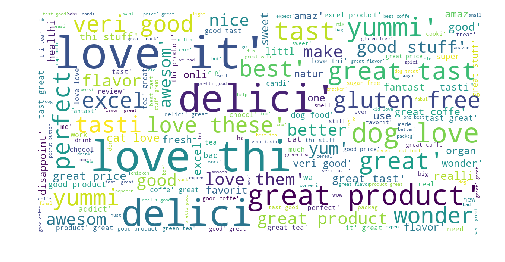

In [155]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib as mpl
import matplotlib.pyplot as plt 
stopwords = set(STOPWORDS)

#mpl.rcParams['figure.figsize']=(8.0,6.0)    #(6.0,4.0)
mpl.rcParams['font.size']=12                #10 
mpl.rcParams['savefig.dpi']=100             #72 
mpl.rcParams['figure.subplot.bottom']=.1 


def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))
    
    fig = plt.figure(1, figsize=(8, 8))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()
    
show_wordcloud(corpus)


## Multinomial Naïve Bayes 


In [156]:
# simple "probabilistic classifiers" based on applying Bayes' theorem with strong (naïve) independence assumptions between the features.
# a popular (baseline) method for text categorization, the problem of judging documents as belonging to one category or the other
# with word frequencies as the features

from sklearn.naive_bayes import MultinomialNB 

model = MultinomialNB().fit(X_train_tfidf, y_train)
prediction['Multinomial'] = model.predict(X_test_tfidf)
print(prediction)

{'Multinomial': array(['negative', 'negative', 'negative', ..., 'negative', 'negative',
       'positive'], dtype='<U8')}


## Bernoulli Naïve Bayes

In [0]:
from sklearn.naive_bayes import BernoulliNB
model = BernoulliNB().fit(X_train_tfidf, y_train)
prediction['Bernoulli'] = model.predict(X_test_tfidf)

## Logistic regression

In [0]:
from sklearn import linear_model
logreg = linear_model.LogisticRegression(C=1e5)
logreg.fit(X_train_tfidf, y_train)
prediction['Logistic'] = logreg.predict(X_test_tfidf)

## Comparing results

AUC (Area Under The Curve) ROC (Receiver Operating Characteristics) curve for checking any classification model’s performance.
Higher the AUC, better the model is at distinguishing between the classes. 
The curve with the highest AUC value will show our "best" algorithm.

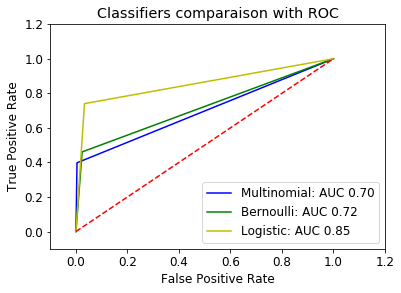

In [159]:
from sklearn.metrics import roc_curve, auc

def formatt(x):
    if x == 'negative':
        return 0
    return 1
vfunc = np.vectorize(formatt)

cmp = 0
colors = ['b', 'g', 'y', 'm', 'k']
for model, predicted in prediction.items():
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test.map(formatt), vfunc(predicted))
    roc_auc = auc(false_positive_rate, true_positive_rate)
    plt.plot(false_positive_rate, true_positive_rate, colors[cmp], label='%s: AUC %0.2f'% (model,roc_auc))
    cmp += 1

plt.title('Classifiers comparaison with ROC')
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

After plotting the ROC curve, it would appear that the Logistic regression method provides us with the best results
We now focus on logistic regression, and vizualise the accuracy, recall and confusion matrix of this model:

In [160]:
from sklearn import metrics
print(metrics.classification_report(y_test, prediction['Logistic'], target_names = ["positive", "negative"]))

              precision    recall  f1-score   support

    positive       0.95      0.97      0.96     61433
    negative       0.81      0.74      0.77     11402

    accuracy                           0.93     72835
   macro avg       0.88      0.85      0.87     72835
weighted avg       0.93      0.93      0.93     72835



# ACC = 0.93

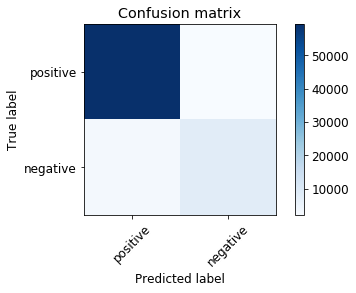

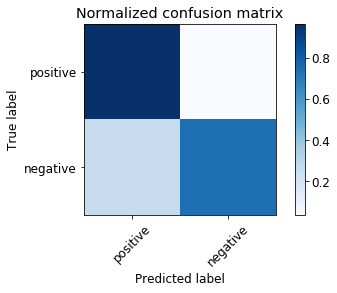

In [161]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(set(Score)))
    plt.xticks(tick_marks, set(Score), rotation=45)
    plt.yticks(tick_marks, set(Score))
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
# Compute confusion matrix
cm = confusion_matrix(y_test, prediction['Logistic'])
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cm)    

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure()
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')

plt.show()